In [1]:
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from torch.optim import RMSprop

import sys
import pandas as pd
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
import numpy as np
import base64
import cv2
import torch
import os
import torch.nn.functional as F
import math
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
import pickle
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import EvalCallback

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import StandardScaler

np.math = math
gym.register_envs(ale_py)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cuda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Establish Control Enviornment

In [3]:
def make_Cartpole_env():
  env = gym.make("CartPole-v1")
  return env

# DQN

In [4]:
from stable_baselines3 import DQN

In [5]:
Cartpole_env = DummyVecEnv([make_Cartpole_env])

# Establish DQN

In [45]:
policy_kwargs = dict(
    net_arch=[256, 256]
)

DQN_model = DQN(
    policy="MlpPolicy",
    env=Cartpole_env,

    learning_rate=2.3e-3,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,

    gamma=0.99,
    target_update_interval=10,

    train_freq=256,
    gradient_steps=128,

    exploration_fraction=0.16,
    exploration_final_eps=0.04,

    policy_kwargs=policy_kwargs,

    verbose=1,
    tensorboard_log="./CartPole/dqn"
)

Using cpu device


# Train DQN

In [46]:
eval_callback = EvalCallback(
    Cartpole_env,
    best_model_save_path="./CartPole/dqn",
    log_path="./CartPole/dqn", 
    eval_freq=100000,  
    n_eval_episodes=10, 
    deterministic=True, 
    render=False,
)

n_timesteps = int(5e4)

DQN_model.learn(total_timesteps=n_timesteps, callback=eval_callback)

DQN_model.save("./CartPole/dqn")

Logging to ./CartPole/dqn\DQN_1
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1512     |
|    time_elapsed     | 0        |
|    total_timesteps  | 59       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2021     |
|    time_elapsed     | 0        |
|    total_timesteps  | 151      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 2380     |
|    time_elapsed     | 0        |
|    total_timesteps  | 259      |
----------------------------------
-----------------------

# Load DQN Model

In [47]:
DQN_model = DQN.load("./CartPole/dqn/dqn.zip")

DQN_model.exploration_final_eps = 0.0
DQN_model.exploration_fraction = 0.0

In [48]:
DQN_q_net = DQN_model.policy.q_net.q_net

# Collect Episode Data

In [49]:
n_envs = 1
Cartpole_env = DummyVecEnv([make_Cartpole_env for _ in range(n_envs)]) 

In [50]:
output_dir = "./CartPole/dqn/evaluation"
os.makedirs(output_dir, exist_ok=True)

num_episodes = 200

episode_records = []

def generate_column_names():
    return [
        "cart_position",
        "cart_velocity",
        "pole_angle",
        "pole_angular_velocity",
        "action",
        "reward"
    ]

for ep in range(1, num_episodes + 1):
    obs = Cartpole_env.reset()
    done = False

    episode_records.clear()

    while not done:
        # ---- CartPole features = raw observation ----
        features = obs[0]             # shape (4,)

        features = np.array(features)

        # ---- policy action ----
        action, _states = DQN_model.predict(obs, deterministic=True)

        # print(action)

        next_obs, reward, done, info = Cartpole_env.step(action)

        action_array = np.array([action]).flatten()
        reward_array = np.array([reward]).flatten()

        record = np.concatenate([
            features,
            action_array,
            reward_array
        ])

        episode_records.append(record)

        obs = next_obs

    # ---- save CSV ----
    file_path = os.path.join(output_dir, f"episode_{ep}.csv")

    df = pd.DataFrame(
        episode_records,
        columns=generate_column_names()
    )
    df.to_csv(file_path, index=False)

    episode_records.clear()

# Merge Episode

In [52]:
def merge_cartpole_episodes(
    episode_dir,
    output_file,
):
    """
    Merge all CartPole episode CSVs into a single step-level dataset.
    """

    merged_records = []

    if os.path.exists(output_file):
        print(f"{output_file} already exists. Skipping merge.")
        return

    for episode_file in sorted(os.listdir(episode_dir)):
        if not episode_file.endswith(".csv"):
            continue

        episode_path = os.path.join(episode_dir, episode_file)
        df = pd.read_csv(episode_path)

        # sanity check
        required_cols = [
            "cart_position",
            "cart_velocity",
            "pole_angle",
            "pole_angular_velocity",
            "action",
            "reward"
        ]
        assert all(col in df.columns for col in required_cols), \
            f"Missing columns in {episode_file}"

        merged_records.append(df.values)

    if len(merged_records) == 0:
        raise RuntimeError("No episode CSV files found.")

    all_data = np.vstack(merged_records)

    merged_df = pd.DataFrame(
        all_data,
        columns=required_cols
    )

    merged_df.to_csv(output_file, index=False)
    print(f"Merged CartPole data saved to {output_file}")

merge_cartpole_episodes(
    episode_dir="./CartPole/dqn/evaluation",
    output_file="./CartPole/dqn/eval_data.csv"
)

Merged CartPole data saved to ./CartPole/dqn/eval_data.csv


# Compute SHAP

In [53]:
# Step 1: Load and prepare the data
data = pd.read_csv('./CartPole/dqn/eval_data.csv')

X = data.drop(columns=['reward', 'action']).values
Y = data['reward'].values
Z = data['action'].values

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
X_tensor[0]

tensor([-0.0239, -0.0419,  0.0386, -0.0473])

In [54]:
DQN_q_net = DQN_model.policy.q_net.q_net

In [55]:
background_size = int(len(X_tensor) * 0.01)  # Choose 1% of the data
background_data = X_tensor[:background_size]

In [ ]:
explainer = shap.DeepExplainer(DQN_q_net, background_data)
shap_values = explainer.shap_values(X_tensor, check_additivity=False)

In [24]:
n_samples, n_features, n_actions = shap_values.shape
feature_names = data.drop(['reward','action'], axis=1).columns.tolist()

actions = Z.astype(int)           # shape = (n_samples,)
sample_idx = np.arange(n_samples) # [0,1,2,…,n_samples-1]

shap_max = shap_values[sample_idx, :, actions]

shap_df = pd.DataFrame(shap_max, columns=feature_names)
shap_df['action'] = Z

out_path = './CartPole/dqn/shap_data.csv'
shap_df.to_csv(out_path, index=False)
print(f"[+] Saved：{out_path}")

[+] Saved：./CartPole/dqn/shap_data.csv


In [14]:
shap_data = pd.read_csv('./CartPole/dqn/shap_data.csv').drop(columns=['action']).values
feature_names = pd.read_csv('./CartPole/dqn/shap_data.csv').drop(['action'], axis=1).columns.tolist()

In [15]:
shap_data[0]

array([ 3.53073478,  1.00855565, -0.25215635, -0.05271596])

In [16]:
X[0]

array([ 0.0288997 , -0.02643833, -0.01388266, -0.0417838 ])

In [17]:
feature_names

['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']

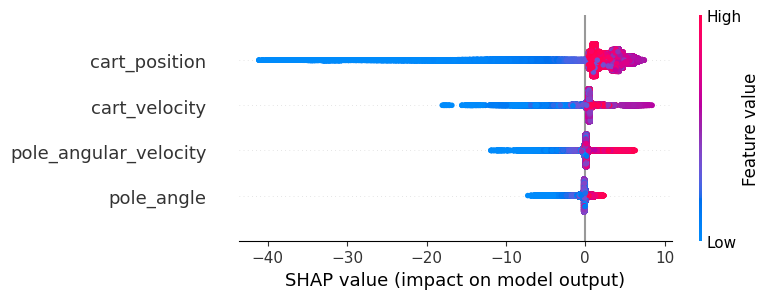

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(10,10))
shap.summary_plot(shap_data, X, feature_names=feature_names)
plt.savefig('./CartPole/dqn/CartPole_DQN_SHAP_value_chart.pdf', format='pdf', bbox_inches='tight')

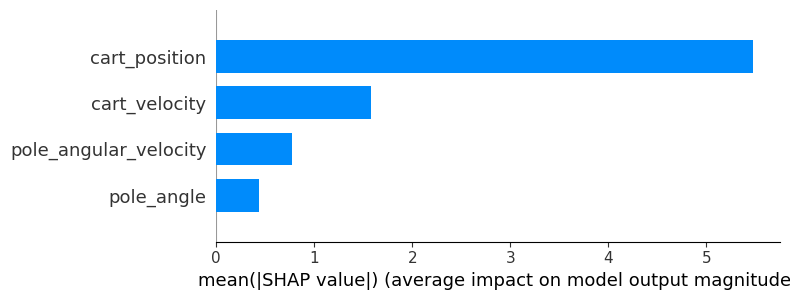

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(10,10))
shap.summary_plot(shap_data, X, feature_names=feature_names, plot_type="bar")
plt.savefig('./CartPole/dqn/CartPole DQN SHAP value bar chart')

In [17]:
shapley_to_state_mapping = {}

for i in range(len(X_tensor)):
    state = X[i]  
    shapley_vector = shap_data[i]  
    
    shapley_to_state_mapping[tuple(shapley_vector)] = state

with open('./CartPole/dqn/shapley_to_state_mapping.pkl', 'wb') as f:
    pickle.dump(shapley_to_state_mapping, f)

print("The mapping between Shapley vectors and the original state space has been saved.")

The mapping between Shapley vectors and the original state space has been saved.


In [18]:
len(shap_data)

100000

In [18]:
print(shapley_to_state_mapping.get(tuple(shap_data[0])))

[ 0.0288997  -0.02643833 -0.01388266 -0.0417838 ]


# Action K-Means Clustering

In [19]:
n_actions = Cartpole_env.action_space.n

kmeans = KMeans(n_clusters=n_actions) 
kmeans.fit(shap_data)

,n_clusters,np.int64(2)
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [20]:
labels = kmeans.labels_

centroids = kmeans.cluster_centers_

print(f"Cluster Labels: {labels}")
print(f"Cluster Centroids: {centroids}")

Cluster Labels: [0 0 0 ... 1 1 1]
Cluster Centroids: [[  2.21222782  -0.34523492   0.03690652   0.17879972]
 [-18.83319147   0.41331515  -0.70780098  -0.82972065]]


# Boundary Points Identification

In [21]:
def find_boundary_points(shap_values, n_clusters):

    boundary_points = []

    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            dist_to_centroids = cdist(shap_values, [centroids[i], centroids[j]], 'euclidean')
                
            dist_diff = np.abs(dist_to_centroids[:, 0] - dist_to_centroids[:, 1])
            boundary_index = np.argmin(dist_diff)
                
            boundary_point = shap_values[boundary_index]
            boundary_points.append((boundary_point, (i, j)))  

    return boundary_points

# Inverse Shapley Values

In [22]:
# find boundary points
boundary_points = find_boundary_points(shap_data, n_clusters=2)

print("boundary_points: ", boundary_points)

# find boundary data
boundary_data = []
# find shap inverse boundary data
shap_inverse_boundary_data = []
# iterate through boundary points
for boundary_point, clusters in boundary_points:

    # get two clusters
    i, j = clusters  

    print("current boundary point:", boundary_point)

    # get shap inverse boundary points
    shap_inverse_boundary_point = shapley_to_state_mapping.get(tuple(boundary_point))

    print("current shap inverse boundary point:", shap_inverse_boundary_point)

    # ---------------- RL-guided Labeling----------------

    action, _ = DQN_model.predict(shap_inverse_boundary_point, deterministic=True)

    print("Predicted action: ", action)

    boundary_data.append(list(boundary_point) + [i, j, action])

    shap_inverse_boundary_data.append(list(shap_inverse_boundary_point) + [i, j, action])

# get features
num_features = len(boundary_data[0]) - 3  

# define columns
columns = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity'] + ['Cluster_1', 'Cluster_2', 'Action_Label']

boundary_df = pd.DataFrame(boundary_data, columns=columns)
shap_inverse_boundary_df = pd.DataFrame(shap_inverse_boundary_data, columns=columns)

boundary_df.to_csv('./CartPole/dqn/boundary_points.csv', index=False)
shap_inverse_boundary_df.to_csv('./CartPole/dqn/shap_inverse_boundary_points.csv', index=False)

boundary_points:  [(array([-8.23369884,  1.34034419,  0.4767192 , -1.54361796]), (0, 1))]
current boundary point: [-8.23369884  1.34034419  0.4767192  -1.54361796]
current shap inverse boundary point: [-0.9250077  -0.21744822  0.02192645 -0.13626799]
Predicted action:  0


In [6]:
bd_data = pd.read_csv('./CartPole/dqn/eval_data.csv')

bd_X = bd_data.iloc[:, :-2].values  

bd_Y = bd_data['action'].values 

In [7]:
bd_X

array([[-0.02387366, -0.04186142,  0.03861084, -0.0473464 ],
       [-0.02471088,  0.15268622,  0.03766391, -0.32760158],
       [-0.02165716,  0.34725228,  0.03111188, -0.60817313],
       ...,
       [-0.13338862, -0.186267  ,  0.02585829,  0.23921056],
       [-0.13711396,  0.00847618,  0.0306425 , -0.04520508],
       [-0.13694443, -0.18707146,  0.0297384 ,  0.25698617]],
      shape=(100000, 4))

In [8]:
bd_Y

array([1., 1., 0., ..., 1., 0., 1.], shape=(100000,))

# Decision Boundary Regression using Linear Regression

### SILVER Framework

In [26]:
# linear regression model from SILVER paper
def SILVER_linear_regression(cart_position, cart_velocity, pole_angle, pole_angular_velocity):
    return -0.5*cart_position - 0.687*cart_velocity - 1.09*pole_angle - pole_angular_velocity - 0.018

### Reshap Framework

In [9]:
Reshap_LinearRegression = LinearRegression()

Reshap_LinearRegression.fit(bd_X, bd_Y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [10]:
coefficient_names = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']

In [11]:
def round_and_clip(predictions, min_value=0, max_value=1):
    predictions_int = np.rint(predictions).astype(int)
    return np.clip(predictions_int, min_value, max_value)

In [12]:
def display_linear_formula(lr, feature_names, F_name='f1', tol=1e-16):

    coefs = lr.coef_.ravel()
    intercept = float(lr.intercept_)
    
    terms = []
    for w, name in zip(coefs, feature_names):

        if abs(w) < tol:
            continue
        sign = "+" if w > 0 else "−"
        terms.append(f"{sign} {abs(w):.2e}·{name}")
    
    if not terms:
        formula = f"{F_name}(x) = {intercept:.2e}"
    else:
        formula = f"{F_name}(x) = {intercept:.2e} " + " ".join(terms)
    
    return formula

In [13]:
display_linear_formula(Reshap_LinearRegression, coefficient_names, F_name="f")

'f(x) = 5.94e-01 + 1.46e+00·cart_position + 1.28e+00·cart_velocity + 3.93e+00·pole_angle + 2.65e+00·pole_angular_velocity'

# Performance Evaluation

In [61]:
def RL_run_episode(env, num_episodes, model):

    rewards = []

    for ep in range(num_episodes):
        obs = env.reset() 
        done = False
        total = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True) 

            next_obs, reward, done, info = env.step(action)

            total += reward
            obs = next_obs       

        rewards.append(total)

    return rewards

def SILVER_run_episode(env, num_episodes, model):

    rewards = []

    for ep in range(num_episodes):
        obs = env.reset() 
        done = False
        total = 0

        while not done:

            cart_position = obs[0][0]
            cart_velocity = obs[0][1]
            pole_angle = obs[0][2]
            pole_angular_velocity = obs[0][3]
            
            # compute result of linear regression
            f = model(cart_position, cart_velocity, pole_angle, pole_angular_velocity)
            
            # select action
            action = [0] if f > 0 else [1]

            next_obs, reward, done, info = env.step(action)

            total += reward
            obs = next_obs
        rewards.append(total)        

    return rewards

def ReShap_run_episode(env, num_episodes, model):

    rewards = []

    for ep in range(num_episodes):
        obs = env.reset() 
        done = False
        total = 0

        while not done:
            
            action = model.predict(obs) 

            if isinstance(model, LinearRegression):
                action = round_and_clip(action)

            next_obs, reward, done, info = env.step(action)

            if reward == [0.]:
                print("reward earned: ", reward)

            total += reward
            obs = next_obs
        rewards.append(total)        

    return rewards

### DQN

In [33]:
DQN_result = RL_run_episode(Cartpole_env, 100, DQN_model) 

print(DQN_result)
print(sum(DQN_result))

[array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([50

In [53]:
DQN_result_np = np.array(DQN_result)
np.save("./CartPole/DQN_result_np.npy", DQN_result_np)

### SILVER

In [35]:
SILVER_result = SILVER_run_episode(Cartpole_env, 100, SILVER_linear_regression) 

print(SILVER_result)
print(sum(SILVER_result))

[array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([50

In [54]:
SILVER_result_np = np.array(SILVER_result)
np.save("./CartPole/DQN_SILVER_result_np.npy", SILVER_result_np)

### Reshap

In [62]:
ReShap_result = ReShap_run_episode(Cartpole_env, 100, Reshap_LinearRegression) 

print(ReShap_result)
print(sum(ReShap_result))

[array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([500.], dtype=float32), array([50

In [63]:
ReShap_result_np = np.array(ReShap_result)
np.save("./CartPole/DQN_ReShap_result_np.npy", ReShap_result_np)